In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploring the importance of clinical and sociodemographic factors on self-rated health in midlife: a cross-sectional study using machine learning

Author: Hisrael Passarelli-Araujo

Email: hisraelpassarelli@cedeplar.ufmg.br


## Abstract
**Background**: Self-rated health (SRH) is influenced by various factors, including clinical and sociodemographic characteristics. However, in the context of Brazil, we still lack a clear understanding of the relative importance of these factors and how they differ between men and women. Given the significance of gender equity in health, it is crucial to explore these differences to meet the specific needs of each group.
**Objective**: This study examines the importance of clinical and sociodemographic factors of SRH among middle-aged Brazilian adults and analyzes how they vary between men and women.
**Methods**: A cross-sectional analysis was conducted using data from the 2019 National Health Survey (PNS) with a representative sample of 31,926 middle-aged adults (40–59 years) living in private households on Brazilian territory. Five machine learning models—Naive Bayes, SVM, Logistic Regression, Random Forests, and XGBoost—were employed to analyze the data.
**Results**: The analysis revealed gender-specific patterns in SRH predictors. For men, education was the most critical factor, followed by diagnoses of physical and mental illnesses. For women, SRH was primarily influenced by chronic disease diagnoses, low education, and health insurance coverage. Alcohol consumption was a stronger predictor of poor SRH for men than women, likely due to cultural norms that promote higher alcohol use among men.
**Conclusion**: This study provides insights into midlife health disparities, emphasizing gender-specific factors influencing SRH. Machine learning demonstrated its value in uncovering nuanced patterns in health data, offering a powerful tool for public health research and policy.


# Libraries

In [1]:
# Base libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


In [2]:
# Auxiliary libraries for processing

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import set_config

#!pip install scikit-learn==1.0.2
import pickle

In [3]:
# Installing packages
!pip install xgboost
!pip install shap

In [4]:
# Libraries for models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [5]:
# # Libraries for model evaluation and metrics
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    matthews_corrcoef,
    RocCurveDisplay,
    DetCurveDisplay
    )

In [6]:
# Libraries for explainability
from sklearn.inspection import permutation_importance
import shap

# Libraries for dimensionality reduction
from sklearn.decomposition import PCA

In [7]:
from xgboost import XGBClassifier

In [8]:
# Importing XGBoost properly
from xgboost import __version__ as xgboost_version
import shap

# Importing scikit-learn's version attribute directly
#from sklearn import __version__ as sklearn_version

# Function to display library versions
def show_versions():
    print("Versions of libraries used in the study:")
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Seaborn: {sns.__version__}")
   # print(f"Scikit-learn: {sklearn_version}")
    print(f"XGBoost: {xgboost_version}")
    print(f"SHAP: {shap.__version__}")

# Call the function to display library versions
show_versions()

Versions of libraries used in the study:
Pandas: 2.2.2
NumPy: 1.26.4
Matplotlib: 3.10.0
Seaborn: 0.13.2
XGBoost: 2.1.3
SHAP: 0.46.0


# About the data

Thi study relied on data from the National Health Survey (PNS) 2019, a nationwide population-based survey conducted in 2019 by the Ministry of Health and the Brazilian Institute of Geography and Statistics (IBGE). The PNS aims to describe the health status and lifestyle of the Brazilian population and is representative of geopolitical macro-regions, states, metropolitan regions, and 27 capitals. The PNS employs a multi-stage probability sampling design, including individuals aged 15 years or older, residing in permanent private households, specifically built for habitation. The sample used in this study includes 31,926 adult individuals aged between 40 and 59 years.

In [39]:
filename = "/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/Database/data_for_python.txt"
df = pd.read_table(filename, delimiter='\t', index_col="subjID", na_values=["NA", "n/a", ""], keep_default_na=False)
df.head()

,age_group,sex,marital_status,situation_household,family_support,friend_support,region,Poor_health,color,education,smoker,disease_diagnosis,diag_cancer,depression,mental_diseases_other,health_insurance,physical_exercise,BMI,obesity,drinking
subjID,,,,,,,,,,,,,,,,,,,,
ID1,55-59,Female,Married,Urbano,Three or more,None,Norte,1,White,Low,No,Yes,No,Yes,No,No,NaN,28.537455,No,Less than one by month
ID2,45-49,Female,Single,Urbano,One,One,Norte,1,Black,Middle,No,No,No,No,No,No,NaN,32.049948,Yes,One or more by month
ID3,55-59,Female,Widowed,Urbano,One,None,Norte,1,Black,Low,No,No,No,No,No,No,Yes,22.151023,No,Never
ID4,40-44,Female,Married,Urbano,Three or more,None,Norte,0,Pardo,Middle,No,No,No,No,No,No,Yes,25.951557,No,Never
ID5,50-54,Female,Single,Urbano,Two,One,Norte,0,Pardo,Low,No,Yes,No,No,No,No,No,23.422368,No,Never


In [10]:
df.shape

(31926, 20)

In [11]:
df.columns

Index(['age_group', 'sex', 'marital_status', 'situation_household',
       'family_support', 'friend_support', 'region', 'Poor_health', 'color',
       'education', 'smoker', 'disease_diagnosis', 'diag_cancer', 'depression',
       'mental_diseases_other', 'health_insurance', 'physical_exercise', 'BMI',
       'obesity', 'drinking'],
      dtype='object')

The raw dataset contains 31,926 instances and 20 features.

In [12]:
# Features

#Demographic
demog = ['age_group', 'sex', 'marital_status', 'color', 'region', 'education', \
         'situation_household', 'family_support', 'friend_support']

# Clinical
clinical = ['smoker', 'disease_diagnosis', 'diag_cancer', 'depression', 'mental_diseases_other' \
       'health_insurance', 'physical_exercise', 'BMI', 'obesity', 'drinking']

Text(0.5, 1.0, "Outcome's distribution (Self-rated health) = 31926")

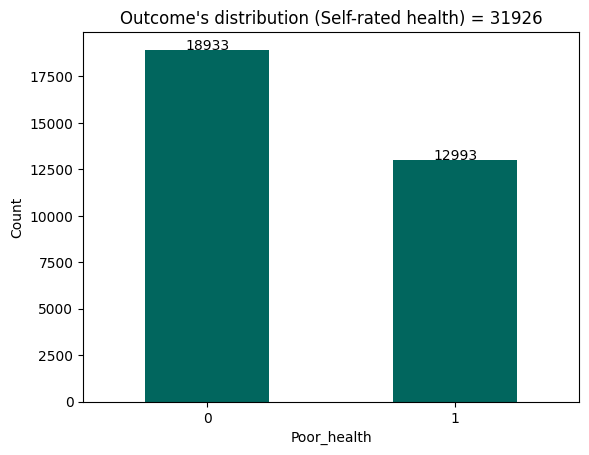

In [13]:
df.Poor_health.value_counts().plot(kind="bar", color='#01665e')

# text above each bar
for idx, value in enumerate(df.Poor_health.value_counts()):
    plt.text(idx, value, str(value), horizontalalignment='center')

plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title(f"Outcome's distribution (Self-rated health) = {df.shape[0]}")

[Text(0, 0, '0 - Good SRH'), Text(1, 0, '1 - Poor SRH')]

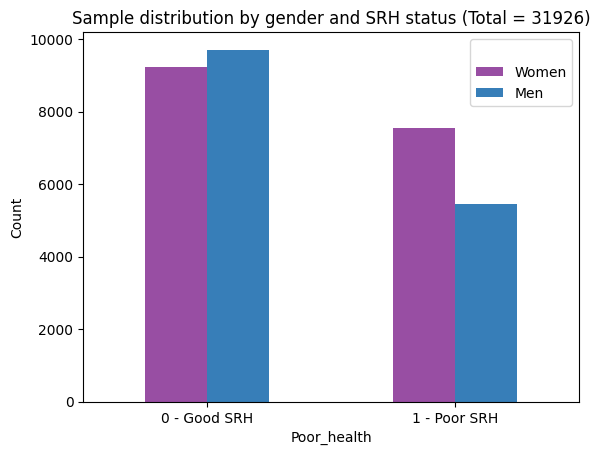

In [15]:
count_data = df.groupby(["Poor_health", "sex"]).size().unstack()

count_data.plot(kind="bar", color=['#984ea3', '#377eb8'])

plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title(f"Sample distribution by gender and SRH status (Total = {df.shape[0]})")
plt.legend(["Women", "Men"], title=" ", loc="upper right")
plt.gca().set_xticklabels(["0 - Good SRH", "1 - Poor SRH"])

## Missing Values

the variable related to physical exercise practice (physical_exercise) was excluded due to a high proportion of missing values, accounting for 73.7% of cases. This decision was based on the potential bias and reduced reliability its inclusion could introduce. For the Body Mass Index (BMI) variable, the backward fill (BFill) imputation method was employed, which fills missing values using the last observed value in the data sequence

In [37]:
df.isna().sum()/df.shape[0]*100

,0
age_group,0.000000
sex,0.000000
marital_status,0.000000
situation_household,0.000000
family_support,0.000000
friend_support,0.000000
region,0.000000
Poor_health,0.000000
color,0.000000
education,0.000000


In [41]:
# BFill method to fill missing values
df[["BMI", "obesity"]] = df[["BMI", "obesity"]].bfill(axis=0)
df = df.drop('physical_exercise', axis=1)

In [42]:
df.isna().sum()/df.shape[0]*100

,0
age_group,0.0
sex,0.0
marital_status,0.0
situation_household,0.0
family_support,0.0
friend_support,0.0
region,0.0
Poor_health,0.0
color,0.0
education,0.0


In [43]:
df.head()

,age_group,sex,marital_status,situation_household,family_support,friend_support,region,Poor_health,color,education,smoker,disease_diagnosis,diag_cancer,depression,mental_diseases_other,health_insurance,BMI,obesity,drinking
subjID,,,,,,,,,,,,,,,,,,,
ID1,55-59,Female,Married,Urbano,Three or more,None,Norte,1,White,Low,No,Yes,No,Yes,No,No,28.537455,No,Less than one by month
ID2,45-49,Female,Single,Urbano,One,One,Norte,1,Black,Middle,No,No,No,No,No,No,32.049948,Yes,One or more by month
ID3,55-59,Female,Widowed,Urbano,One,None,Norte,1,Black,Low,No,No,No,No,No,No,22.151023,No,Never
ID4,40-44,Female,Married,Urbano,Three or more,None,Norte,0,Pardo,Middle,No,No,No,No,No,No,25.951557,No,Never
ID5,50-54,Female,Single,Urbano,Two,One,Norte,0,Pardo,Low,No,Yes,No,No,No,No,23.422368,No,Never


# Train and Test Set Split
In this project, I will use 25% of the data for testing. Additionally, since there is a class imbalance issue, I will perform stratified sampling to split the data.

In [44]:
X = df.drop(columns="Poor_health")
y = df["Poor_health"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22, stratify=y)

# Pipeline e data transformation


In [45]:
categorical_features = ['sex', 'marital_status', 'situation_household', \
                        'region', 'color',  'smoker', 'disease_diagnosis', 'depression', \
       'diag_cancer', 'mental_diseases_other', 'health_insurance', 'obesity', 'drinking']
numeric_features = ['BMI']
multilabel_features = ['age_group','family_support', 'friend_support', 'education']

# transformer
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features+multilabel_features)
    ]
)

# Models
I will compare five different algorithms:

- Naive Bayes
- Logistic Regression
- Support Vector Machines (SVMs)
- Random Forests
- XGBoost





The code below tests multiple hyperparameters simultaneously, computes accuracy, and also calculates the Matthews correlation coefficient, a useful metric for evaluating binary classification problems in datasets with imbalanced classes.

The hyperparameters will be tuned using Grid Search with folds varying from 2 to 8. The performance of each model will later be plotted as a function of the number of folds.

In [46]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

def grid_to_evaluate_models(X, y, cv=8):
    Pipeline(steps=[("preprocessor", preprocessor), ("clf", GaussianNB())])

    all_models = {

    "naive_bayes" : {
        "base_model": Pipeline(steps=[("preprocessor", preprocessor), ("clf", GaussianNB())]),
        "params": {
            'clf__var_smoothing': np.logspace(0,-9,num=100)},
        "cv":[],
        "best_model":[],
        "mcc":[],
        "acc":[]},

    "log_reg" : {
        "base_model": Pipeline(steps=[("preprocessor", preprocessor), ("clf", LogisticRegression(solver="liblinear"))]),
        "params": {
            'clf__C': [0.1,1.0,10]},
        "cv":[],
        "best_model":[],
        "mcc":[],
        "acc":[]},

    "svm" : {
        "base_model":  Pipeline(steps=[("preprocessor", preprocessor), ("clf", SVC(random_state=1))]),
        "params": {
            'clf__C': [0.1,1.0],
            'clf__gamma' : [0.1, 1.0]},
        "cv":[],
        "best_model":[],
        "mcc":[],
        "acc":[]},

    "random_forest" : {
        "base_model": Pipeline(steps=[("preprocessor", preprocessor), ("clf", RandomForestClassifier(random_state=1,n_jobs=-1))]),
        "params": {
            'clf__max_depth': [3,5,12,20],
            'clf__max_features': [3,5,10,20]},
        "cv":[],
        "best_model":[],
        "mcc":[],
        "acc":[]},

    "xgboost" : {
        "base_model": Pipeline(steps=[("preprocessor", preprocessor), ("clf", XGBClassifier(random_state=1, verbosity=0, n_jobs=-1, use_label_encoder=False))]),
        "params": {
            'clf__min_child_weight': [1, 5, 10],
            'clf__gamma': [0.5, 1, 1.5],
            'clf__colsample_bytree': [0.6, 1.0],
            'clf__max_depth': [3, 4, 5]},
        "cv":[],
        "best_model":[],
        "mcc":[],
        "acc":[]}
    }

    # Folds para cada modelo em Grid
    for fold in range(2,cv+1):
        print(f'\n ---- Fold = {fold} ----\n')

        # Naive Bayes
        print("Naive Bayes\n")
        grid = GridSearchCV(
            estimator=all_models["naive_bayes"]["base_model"],
            param_grid=all_models["naive_bayes"]["params"],
            cv=fold,
            scoring='accuracy',
            verbose=False
            )
        grid.fit(X,y)
        predict = cross_val_predict(grid.best_estimator_, X, y, cv=fold)

        all_models["naive_bayes"]["cv"].append(fold)
        all_models["naive_bayes"]["best_model"].append(grid.best_estimator_)
        all_models["naive_bayes"]["mcc"].append(matthews_corrcoef(y, predict))
        all_models["naive_bayes"]["acc"].append(balanced_accuracy_score(y, predict))

        # Logistic Regression
        print("Logistic Regression\n")
        grid = GridSearchCV(
            estimator=all_models["log_reg"]["base_model"],
            param_grid=all_models["log_reg"]["params"],
            cv=fold,
            scoring='accuracy',
            verbose=False
            )
        grid.fit(X,y)
        predict = cross_val_predict(grid.best_estimator_, X, y, cv=fold)

        all_models["log_reg"]["cv"].append(fold)
        all_models["log_reg"]["best_model"].append(grid.best_estimator_)
        all_models["log_reg"]["mcc"].append(matthews_corrcoef(y, predict))
        all_models["log_reg"]["acc"].append(balanced_accuracy_score(y, predict))

        # Support Vector Machine
        print("Support Vector Machine\n")
        grid = GridSearchCV(
            estimator=all_models["svm"]["base_model"],
            param_grid=all_models["svm"]["params"],
            cv=fold,
            scoring='accuracy',
            verbose=False
            )
        grid.fit(X,y)
        predict = cross_val_predict(grid.best_estimator_, X, y, cv=fold)

        all_models["svm"]["cv"].append(fold)
        all_models["svm"]["best_model"].append(grid.best_estimator_)
        all_models["svm"]["mcc"].append(matthews_corrcoef(y, predict))
        all_models["svm"]["acc"].append(balanced_accuracy_score(y, predict))

        # Random Forests
        print("Random Forests\n")
        grid = GridSearchCV(
            estimator=all_models["random_forest"]["base_model"],
            param_grid=all_models["random_forest"]["params"],
            cv=fold,
            scoring='accuracy',
            verbose=False
            )
        grid.fit(X,y)
        predict = cross_val_predict(grid.best_estimator_, X, y, cv=fold)

        all_models["random_forest"]["cv"].append(fold)
        all_models["random_forest"]["best_model"].append(grid.best_estimator_)
        all_models["random_forest"]["mcc"].append(matthews_corrcoef(y, predict))
        all_models["random_forest"]["acc"].append(balanced_accuracy_score(y, predict))

        # XGBoost
        print("XGBoost\n")
        grid = GridSearchCV(
            estimator=all_models["xgboost"]["base_model"],
            param_grid=all_models["xgboost"]["params"],
            cv=fold,
            scoring='accuracy',
            verbose=False
            )
        grid.fit(X,y)
        predict = cross_val_predict(grid.best_estimator_, X, y, cv=fold)

        all_models["xgboost"]["cv"].append(fold)
        all_models["xgboost"]["best_model"].append(grid.best_estimator_)
        all_models["xgboost"]["mcc"].append(matthews_corrcoef(y, predict))
        all_models["xgboost"]["acc"].append(balanced_accuracy_score(y, predict))


    return all_models



The `grid_to_evaluate_models` function takes the input data `X` and `y`, as well as the number of folds `cv`. The function returns a dictionary called `all_models` containing information about each evaluated model.

The function uses a dictionary named `all_models` to store information for each model. Each model is identified by a unique key (e.g., `"naive_bayes"`, `"log_reg"`, etc.) and includes the following details:

- `"base_model"`: The base pipeline model, including preprocessing steps, feature selection, and the model-specific classifier.  
- `"params"`: The hyperparameters to be tested using Grid Search.  
- `"cv"`: An empty list to store the number of folds used for each model.  
- `"best_model"`: An empty list to store the best model found by Grid Search for each model.  
- `"mcc"`: An empty list to store the Matthews correlation coefficient calculated for each model.  
- `"acc"`: An empty list to store the balanced accuracy calculated for each model.  

The function then iterates over the range of folds, from 2 to `cv+1`. For each number of folds, the code performs the following procedure for each model:

1. Uses `GridSearchCV` to perform a grid search to find the best hyperparameters for the model, using the current number of folds for cross-validation.  
2. Executes cross-prediction (`cross_val_predict`) with the best estimator found by Grid Search.  
3. Stores the number of folds used, the best model found, the Matthews correlation coefficient, and the balanced accuracy in the respective fields of the `all_models` dictionary for the current model.  

At the end, the function returns the `all_models` dictionary containing the collected information for each model evaluated with different numbers of folds.

This code enables the evaluation and comparison of multiple machine learning models with various hyperparameter configurations using Grid Search and different numbers of folds. The results are stored in the `all_models` dictionary for later analysis and selection of the best model based on performance metrics.

In [ ]:
#all_models = grid_to_evaluate_models(X=X_train,
                                     #y=y_train,
                                     #cv=8)

The final dictionary was saved using pickle. The previous process took approximately **2 hours to complete**. Due to size limitations, I couldn't upload the final dictionary to GitHub, but you can generate it by running the code in Python.

In [ ]:
#Writing
#with open("/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/Database/ml_all_models_dict.pkl", "wb") as fh: #we need to save as binary as well
    #pickle.dump(all_models, fh)


 #Loading the model

with open("/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/Database/ml_all_models_dict.pkl", "rb") as fh:
    all_models = pickle.load(fh)

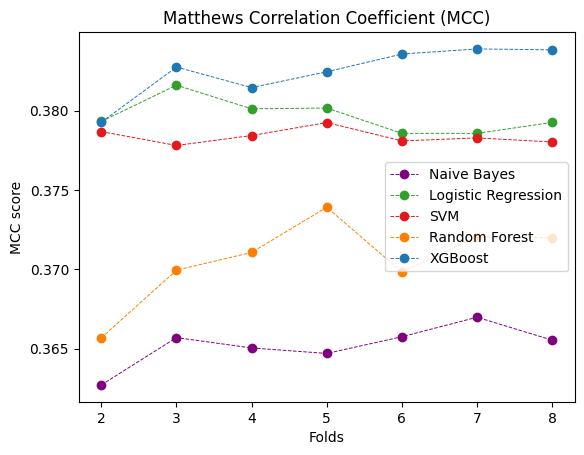

In [49]:
plt.plot(all_models["naive_bayes"]["cv"], all_models["naive_bayes"]["mcc"],
         ls='--',
         lw=0.7,
         color="purple",
         marker="o",
         label="Naive Bayes")

plt.plot(all_models["log_reg"]["cv"], all_models["log_reg"]["mcc"],
         ls='--',
         lw=0.7,
         color="#33a02c",
         marker="o",
         label="Logistic Regression")

plt.plot(all_models["svm"]["cv"], all_models["svm"]["mcc"],
         ls='--',
         lw=0.7,
         color="#e31a1c",
         marker="o",
         label="SVM")
plt.plot(all_models["random_forest"]["cv"], all_models["random_forest"]["mcc"],
         ls='--',
         lw=0.7,
         color="#ff7f00",
         marker="o",
         label="Random Forest")
plt.plot(all_models["xgboost"]["cv"], all_models["xgboost"]["mcc"],
         ls='--',
         lw=0.7,
         color="#1f78b4",
         marker="o",
         label="XGBoost")
plt.legend()
plt.ylabel("MCC score")
plt.xlabel("Folds")
plt.title("Matthews Correlation Coefficient (MCC)")
#plt.ylim([0.525, 0.681])
plt.show()
plt.close()

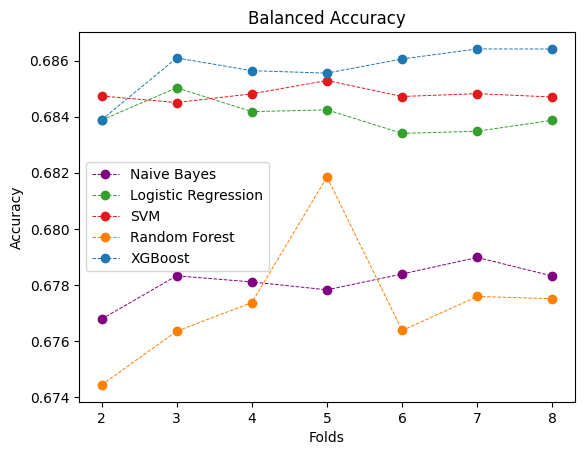

In [54]:
plt.plot(all_models["naive_bayes"]["cv"], all_models["naive_bayes"]["acc"],
         ls='--',
         lw=0.7,
         color="purple",
         marker="o",
         label="Naive Bayes")

plt.plot(all_models["log_reg"]["cv"], all_models["log_reg"]["acc"],
         ls='--',
         lw=0.7,
         color="#33a02c",
         marker="o",
         label="Logistic Regression")

plt.plot(all_models["svm"]["cv"], all_models["svm"]["acc"],
         ls='--',
         lw=0.7,
         color="#e31a1c",
         marker="o",
         label="SVM")
plt.plot(all_models["random_forest"]["cv"], all_models["random_forest"]["acc"],
         ls='--',
         lw=0.7,
         color="#ff7f00",
         marker="o",
         label="Random Forest")
plt.plot(all_models["xgboost"]["cv"], all_models["xgboost"]["acc"],
         ls='--',
         lw=0.7,
         color="#1f78b4",
         marker="o",
         label="XGBoost")
plt.legend()
plt.title("Balanced Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Folds")
#plt.ylim([0.625, 0.681])
plt.show()
plt.close()

According to the plots above, both in terms of the MCC metric and balanced accuracy, the XGBoost model outperforms the others in most of the K chosen for cross-validation.

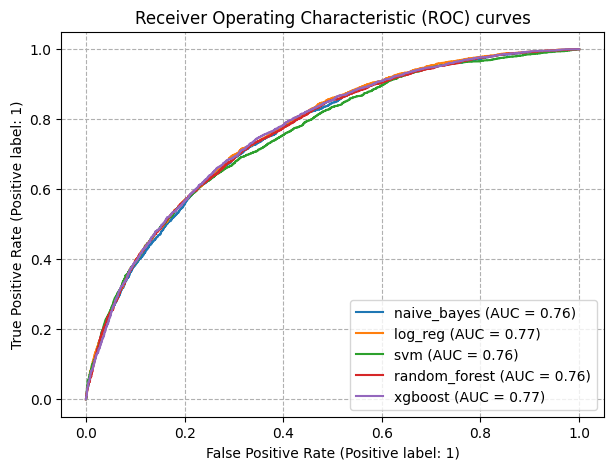

In [51]:
classifiers = dict()
for k, v in all_models.items():
    classifiers[k] = v["best_model"][-1]

fig, ax_roc = plt.subplots(figsize=(7, 5))

for name, clf in classifiers.items():
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_roc.grid(linestyle="--")

plt.legend()


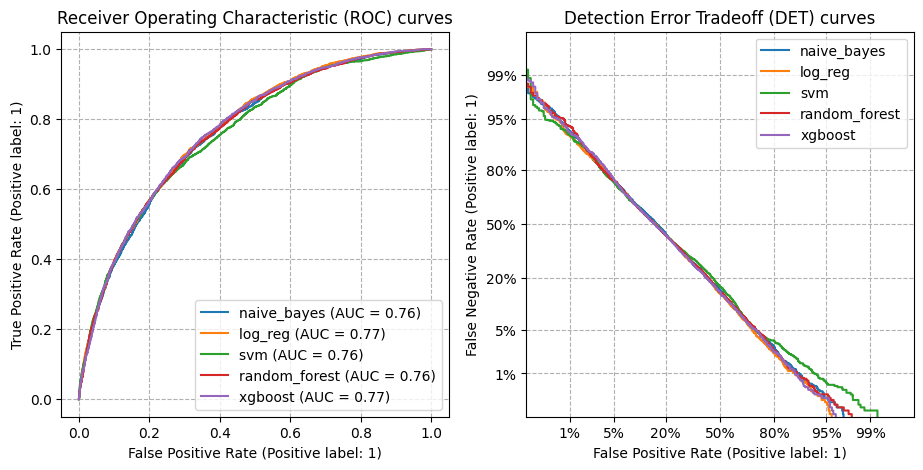

In [53]:

classifiers = dict()
for k,v in all_models.items():
    classifiers[k]=v["best_model"][-1]


fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    #clf.fit(preprocessor.fit_transform(X_train), y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()

From the ROC and DET curves, we observe that all models exhibit excellent and similar performance. However, based on the balanced accuracy and MCC criteria, the XGBoost model was selected for downstream analyses.

# XGBoost Model
As shown earlier, the XGBoost model demonstrated the best performance compared to the others. Therefore, it was used to obtain a more detailed analysis of the key model evaluation metrics.

### Tuning and Feature selection

In [57]:
#predictions
y_pred = xgb_model.predict(X_test)
y_pred.shape

(7982,)

In [58]:
# ROC curve
from sklearn.metrics import precision_recall_curve

probas_pred = xgb_model.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_true = y_test, probas_pred=probas_pred[:,-1])

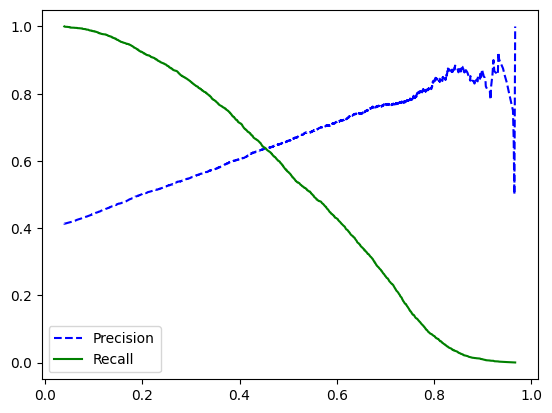

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0.5, 1.0, 'Confusion Matrix')

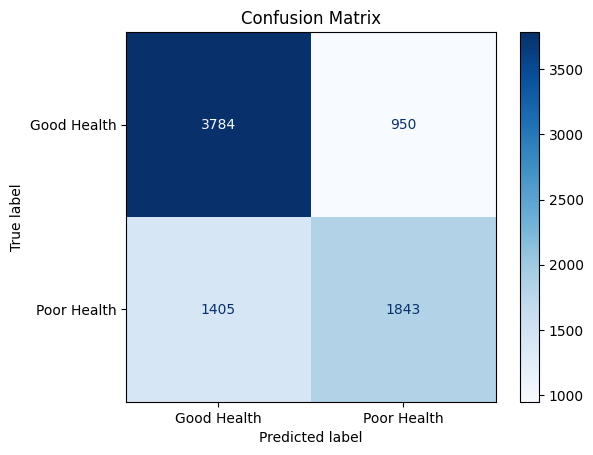

In [61]:
ConfusionMatrixDisplay.from_predictions(
    y_pred=y_pred,
    y_true=y_test,
    cmap=plt.cm.Blues,
    display_labels=["Good Health","Poor Health"])
plt.title("Confusion Matrix")


In [63]:
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):.2f}')
print(f'Precision = {precision_score(y_true=y_test, y_pred=y_pred):.2f}')
print(f'Recall = {recall_score(y_true=y_test, y_pred=y_pred):.2f}')
print(f'F1 Score = {f1_score(y_true=y_test, y_pred=y_pred):.2f}')

Accuracy = 0.70
Precision = 0.66
Recall = 0.57
F1 Score = 0.61


In [ ]:
# how many features entered for the selection
#obj_feat_sel = xgb_model["feature_selection"]
#obj_feat_sel.n_features_in_

In [ ]:
#selected_features = list(xgb_model["feature_selection"].get_feature_names_out())
#print(f'Number of features selected : {len(selected_features)}\n{selected_features}')

## Probability Prediction and Calibration
Since we will work with the probability of poor SRH in some downstream steps, we will perform calibration to ensure everything is accurate.

In [64]:
# Prediction of the probability for an individual in the test set.
xgb_pred = xgb_model.predict_proba(X_test)
poor_health_prob = xgb_pred[:,1][y_test == 0]

In [65]:
# Spliting the probability of poor SRH into bins.
xgb_pred[:,1][y_test == 0]

array([0.16956568, 0.09274273, 0.48687935, ..., 0.7524868 , 0.5099865 ,
       0.15035662], dtype=float32)

In [66]:
#  People who reported poor SRH by binX

b1 = len(poor_health_prob[(poor_health_prob>=0.0) & (poor_health_prob<0.2)])
b2 = len(poor_health_prob[(poor_health_prob>=0.2) & (poor_health_prob<0.4)])
b3 = len(poor_health_prob[(poor_health_prob>=0.4) & (poor_health_prob<0.6)])
b4 = len(poor_health_prob[(poor_health_prob>=0.6) & (poor_health_prob<0.8)])
b5 = len(poor_health_prob[(poor_health_prob>=0.8) & (poor_health_prob<1.0)])

In [67]:
# General number of people in bins

gen_prob = xgb_pred[:,1]

g1 = len(gen_prob[(gen_prob>=0.0) & (gen_prob<0.2)])
g2 = len(gen_prob[(gen_prob>=0.2) & (gen_prob<0.4)])
g3 = len(gen_prob[(gen_prob>=0.4) & (gen_prob<0.6)])
g4 = len(gen_prob[(gen_prob>=0.6) & (gen_prob<0.8)])
g5 = len(gen_prob[(gen_prob>=0.8) & (gen_prob<=1.0)])

In [68]:
# Probabilities of reporting self-rated health as poor
pos = [1-round(b1/g1,3), 1-round(b2/g2,3), 1-round(b3/g3,3), 1-round(b4/g4,3), 1-round(b5/g5,3)]
pos

[0.125, 0.31599999999999995, 0.491, 0.694, 0.84]

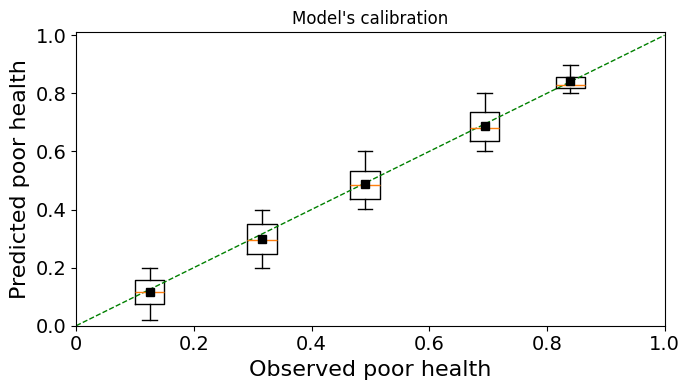

In [69]:
fig = plt.figure(1, figsize=(7, 4))

ax = fig.add_subplot(111)

# Bootstrap
all_data = [poor_health_prob[(poor_health_prob>=0.0) & (poor_health_prob<0.2)],
            poor_health_prob[(poor_health_prob>=0.2) & (poor_health_prob<0.4)],
            poor_health_prob[(poor_health_prob>=0.4) & (poor_health_prob<0.6)],
            poor_health_prob[(poor_health_prob>=0.6) & (poor_health_prob<0.8)],
            poor_health_prob[(poor_health_prob>=0.8) & (poor_health_prob<=1.0)]]


# Boxplot
bp = ax.boxplot(all_data, widths = 0.05, positions=pos, showfliers=False, sym='k+', showmeans=True, \
meanprops={"marker":"s","markerfacecolor":"black","markeredgecolor":"black"}, bootstrap=12000)


plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Predicted poor health',fontsize=16)
plt.xlabel('Observed poor health',fontsize=16)
plt.title("Model's calibration")
plt.setp(bp['fliers'], markersize=3.0)
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], 'g--',linewidth=1)
plt.xticks([0,0.2,0.4,0.6,0.8,1], [0,0.2,0.4,0.6,0.8,1.0])
plt.tight_layout()

According to the results shown in the boxplot above, the self-rated health predicted by the selected XGBoost model behaves consistently across the bins of observed self-rated health.

# Model Explainability - SHAP
To evaluate the importance of variables in the model's "explainability", we adopted SHAP values (Shapley Additive exPlanations). The essence of SHAP is to measure the contribution of each feature for each individual to the outcome and determine whether the feature has a positive or negative impact on the predictions.

Regarding the technical implementation here, a small adjustment to the input data was necessary because the SHAP function does not accept a Pipeline object, as used so far. Therefore, the preprocessing step and column naming will be performed separately.


In [71]:
list_numeric_names = list(xgb_model["preprocessor"].transformers_[0][1].get_feature_names_out(numeric_features))
list_cat_names = list(xgb_model["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_features+multilabel_features))
features_names = list_numeric_names+list_cat_names

In [72]:
features_names[0:6]

['BMI',
 'sex_Female',
 'sex_Male',
 'marital_status_Divorced',
 'marital_status_Married',
 'marital_status_Single']

In [73]:
X_df = pd.DataFrame(preprocessor.fit_transform(X_test))
X_df.columns =features_names

#Dataframe X_test já preprocessado e com os nomes corretos.
X_df.head()

,BMI,sex_Female,sex_Male,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed,situation_household_Rural,situation_household_Urbano,region_Centro-Oeste,...,family_support_One,family_support_Three or more,family_support_Two,friend_support_None,friend_support_One,friend_support_Three or more,friend_support_Two,education_High,education_Low,education_Middle
0,0.259126,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.363404,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.290348,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.446845,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.416620,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [74]:
explainer = shap.TreeExplainer(xgb_model["clf"])
shap_values = explainer.shap_values(X_df)

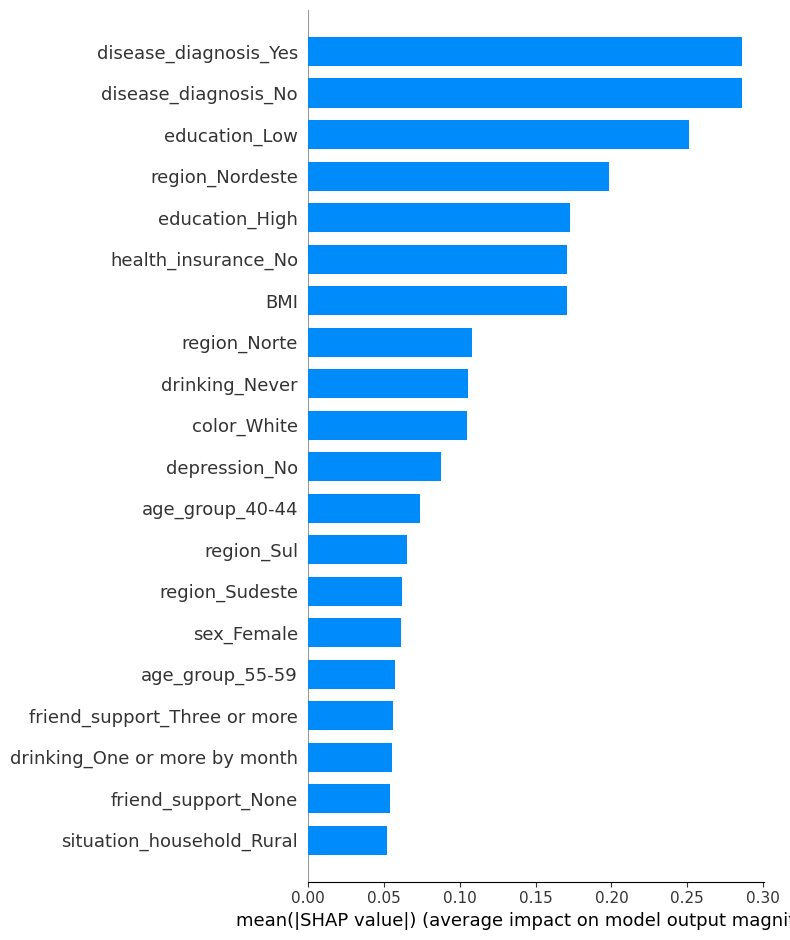

In [75]:
fig = plt.figure()
shap.summary_plot(shap_values, X_df, plot_type='bar')


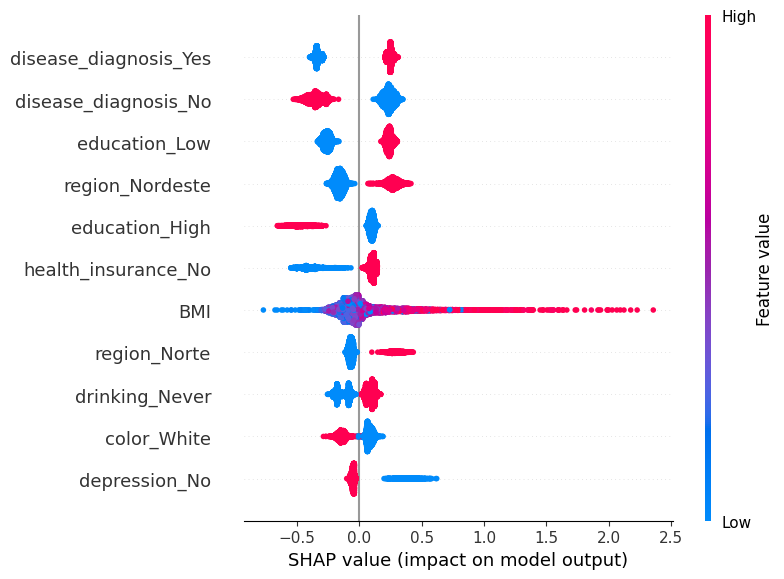

In [76]:
shap.summary_plot(shap_values, X_df,max_display=11,show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(30)